In [1]:
import polars as pl
import pandas as pd
import json
from tqdm import tqdm
import pickle

In [2]:
checkpoint = 'nmr2struct_up_propper_fixed_frags_vocab_10'

In [3]:
with open(f'nmr2struct/data/{checkpoint}_frags_comparison.pkl', 'rb') as handle:
    frags_comparison = pickle.load(handle)

In [4]:
df = pl.read_csv('nmr2struct/data/spec_df.csv', separator='\t', truncate_ragged_lines=True)

In [5]:
signals = df['signals'].str.json_decode()

In [6]:
frags_comparison['spectrum'] = []

In [7]:
for idx in tqdm(frags_comparison['id']):
    frags_comparison['spectrum'].append(signals[idx])

100%|█████████████████████████████████████████████████████████| 266542/266542 [00:00<00:00, 649900.49it/s]


In [8]:
with open('nmr2struct/fp2frags.json') as f:
    fp2_dict = json.loads(f.read())

In [9]:
fp2 = []
for x in fp2_dict.keys():
    fp2.append(x)

In [10]:
frags_comparison['generated_sm'] = []
frags_comparison['actual_sm'] = []

In [11]:
for frags in tqdm(frags_comparison['actual']):
    frag_sm = []
    for x in set(frags):
        if x < len(fp2):
            frag_sm.append(fp2[x])
        else:
            frag_sm.append('')
        
    frags_comparison['actual_sm'].append(frag_sm)


100%|███████████████████████████████████████████████████████████| 266542/266542 [01:49<00:00, 2428.78it/s]


In [12]:
for frags in tqdm(frags_comparison['generated']):
    frag_sm = []
    for x in set(frags):
        if x < len(fp2):
            frag_sm.append(fp2[x])
        else:
            frag_sm.append('')
        
    frags_comparison['generated_sm'].append(frag_sm)

100%|██████████████████████████████████████████████████████████| 266542/266542 [00:16<00:00, 16087.57it/s]


In [13]:
with open(f'nmr2struct/data/{checkpoint}_pediction_with_sm.pkl', 'wb') as handle:
    pickle.dump(frags_comparison, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
frags_comparison.keys()

dict_keys(['id', 'generated', 'actual', 'spectrum', 'generated_sm', 'actual_sm'])

In [15]:
def accuracy(
    a,
    b
) -> float:
    
    return 2 * np.intersect1d(a.numpy(), b.numpy()).shape[0] / (len(set(b.tolist())) + len(set(a.tolist())))

In [16]:
val_acc = []

In [17]:
import numpy as np

In [19]:
for i in tqdm(range(len(frags_comparison['generated']))):
    val_acc.append(
        accuracy(frags_comparison['generated'][i].to('cpu'),
            frags_comparison['actual'][i].to('cpu')
        )
    )

100%|██████████████████████████████████████████████████████████| 266542/266542 [00:10<00:00, 25047.74it/s]


In [20]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Accuracy')

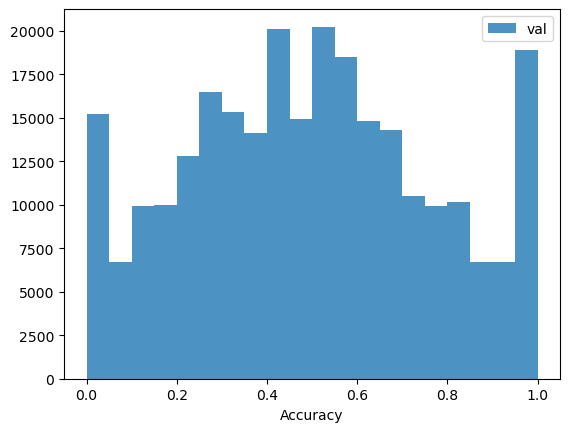

In [21]:
plt.hist(val_acc, alpha=0.8, label='val', bins=20)
plt.legend()
plt.xlabel('Accuracy')

In [22]:
good_pairs = []
for i in range(len(val_acc)):
    if val_acc[i] == 1:
        good_pairs.append([frags_comparison['generated'][i], frags_comparison['actual'][i]])

In [23]:
len(good_pairs)

15736